In [1]:
import pandas as pd
import numpy as np

# Load the messy dataset we created in Level 3
df_messy = pd.read_csv("ncd_stock_data_dynamic_messy.csv")

In [2]:
df_messy.head()

,Date,Drug,Opening_Balance,Quantity_Received,Consumption,Losses_Adjustments,Closing_Balance,Days_Out_of_Stock
0,2020-01-01,Amlodipine 5mg,8481,0,3063.0,12,5406,0
1,2020-02-01,Amlodipine 5mg,5406,0,2628.0,106,2672,0
2,2020-03-01,Amlodipine 5mg,2672,8481,2648.0,9,8496,0
3,2020-04-01,Amlodipine 5mg,8496,0,NaN,79,8417,0
4,2020-05-01,Amlodipine 5mg,8417,0,3190.0,153,5074,0


In [3]:
df_messy.shape

(720, 8)

In [4]:
df_messy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                720 non-null    object 
 1   Drug                720 non-null    object 
 2   Opening_Balance     720 non-null    int64  
 3   Quantity_Received   720 non-null    int64  
 4   Consumption         653 non-null    float64
 5   Losses_Adjustments  720 non-null    int64  
 6   Closing_Balance     720 non-null    int64  
 7   Days_Out_of_Stock   720 non-null    int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 45.1+ KB


# Section 3: Systematic Diagnosis of Data Errors
*Goal: Investigate and quantify each of the data quality issues found in the vitals check.*

In [5]:
# Calculate the number of missing values in 'Consumption'
missing_count = df_messy['Consumption'].isnull().sum()

# Calculate the total number of rows
total_rows = len(df_messy)

# Calculate the percentage
missing_percentage = (missing_count / total_rows) * 100

print(f"Number of missing consumption values: {missing_count}")
print(f"Percentage of missing values: {missing_percentage:.2f}%")

Number of missing consumption values: 67
Percentage of missing values: 9.31%


In [6]:
# Find all rows where Consumption is less than 0
negative_consumption = df_messy[df_messy['Consumption'] < 0]

print(f"Found {len(negative_consumption)} rows with negative consumption:")
display(negative_consumption) # 'display()' is better than 'print()' for DataFrames in a notebook

Found 3 rows with negative consumption:


,Date,Drug,Opening_Balance,Quantity_Received,Consumption,Losses_Adjustments,Closing_Balance,Days_Out_of_Stock
137,2021-06-01,Metformin 500mg,2097,4581,-50.0,40,6688,0
427,2020-08-01,Atenolol 50mg,1627,0,-50.0,10,1667,0
657,2024-10-01,Methyldopa 250mg,4122,0,-50.0,63,4109,0


# Section 4: The "Treatment" Phase - Data Cleaning
*Goal: Execute the cleaning plan to create a new, analysis-ready DataFrame.*


In [7]:
# Create a copy of the messy DataFrame to work on, preserving the original
df_clean = df_messy.copy()

In [8]:
# Treatment 1: Fix incorrect data types
# We will convert 'Date' to a proper datetime object
df_clean['Date'] = pd.to_datetime(df_clean['Date'])

# We will convert 'Opening_Balance' to a numeric type
# errors='coerce' will turn any values that CAN'T be converted into NaN (missing)
df_clean['Opening_Balance'] = pd.to_numeric(df_clean['Opening_Balance'], errors='coerce')

print("Data types after conversion:")
df_clean.info()

Data types after conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                720 non-null    datetime64[ns]
 1   Drug                720 non-null    object        
 2   Opening_Balance     720 non-null    int64         
 3   Quantity_Received   720 non-null    int64         
 4   Consumption         653 non-null    float64       
 5   Losses_Adjustments  720 non-null    int64         
 6   Closing_Balance     720 non-null    int64         
 7   Days_Out_of_Stock   720 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 45.1+ KB


In [9]:
# Treatment 2: Remove impossible values (negatives and outliers)

# First, let's see how many rows we have before cleaning
print(f"Rows before cleaning impossible values: {len(df_clean)}")

# Remove rows where Consumption is negative
df_clean = df_clean[df_clean['Consumption'] >= 0]

# Remove rows where Consumption is an extreme outlier (let's use > 10000)
df_clean = df_clean[df_clean['Consumption'] <= 10000]

print(f"Rows after cleaning impossible values: {len(df_clean)}")

Rows before cleaning impossible values: 720
Rows after cleaning impossible values: 637


### Treatment 3: Impute Missing Consumption Values
*We will fill the missing `Consumption` values with the median consumption for that specific drug. This is more accurate than using a single global median.*

In [10]:
# Calculate the median consumption for EACH drug
drug_medians = df_clean.groupby('Drug')['Consumption'].transform('median')

# Fill the missing values in the 'Consumption' column with the calculated medians
df_clean['Consumption'].fillna(drug_medians, inplace=True)

print("Missing values after imputation:")
print(df_clean.isnull().sum())

Missing values after imputation:
Date                  0
Drug                  0
Opening_Balance       0
Quantity_Received     0
Consumption           0
Losses_Adjustments    0
Closing_Balance       0
Days_Out_of_Stock     0
dtype: int64


C:\Users\DELL\AppData\Local\Temp\ipykernel_29716\3783549214.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['Consumption'].fillna(drug_medians, inplace=True)


# Section 4 Complete: Data is Now Clean
*The dataset is now clean, with correct data types, no impossible values, and no missing data. It is ready for exploratory analysis.*

# Section 5: Health Assessment & Insights
*Goal: Explore the clean data to find initial trends and patterns that could inform our model.*

--- Top 10 Most Consumed Drugs ---
Drug
Nifedipine 20mg              162478.0
Bendroflumethiazide 2.5mg    143911.0
Amlodipine 5mg               141372.0
Soluble Aspirin 75mg         139904.0
Losartan 50mg                112843.0
Hydralazine 25mg             108792.0
Atenolol 50mg                103460.0
Metformin 500mg               81653.0
Glibenclamide 5mg             79487.0
Lisinopril 10mg               64536.0
Name: Consumption, dtype: float64


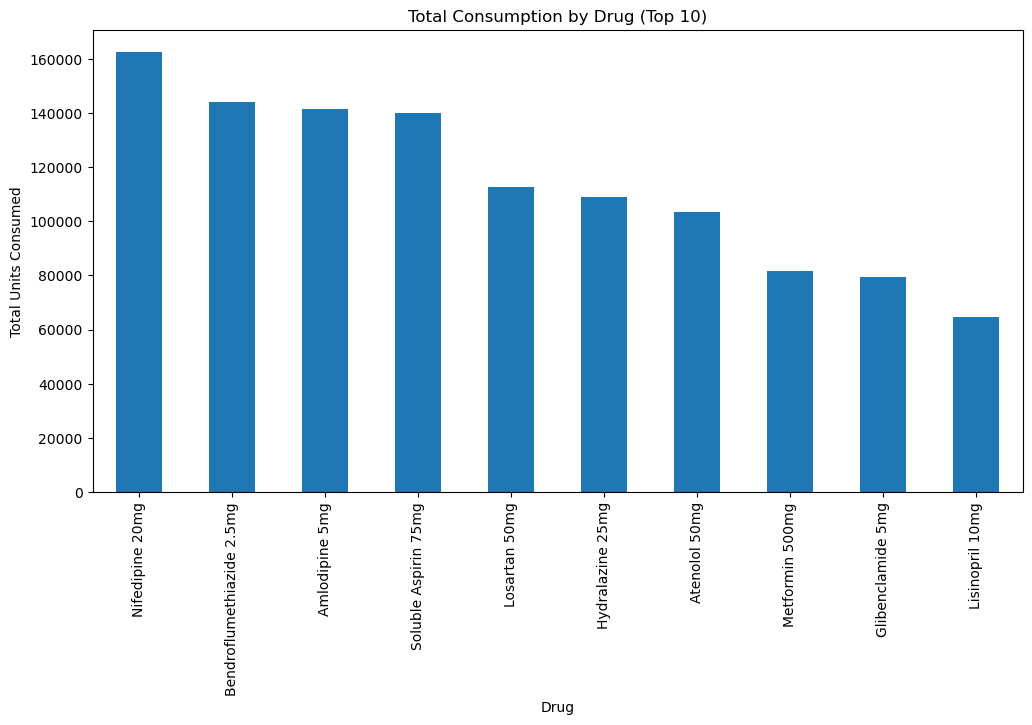

In [11]:
# We need this library for plotting
import matplotlib.pyplot as plt

print("--- Top 10 Most Consumed Drugs ---")
consumption_by_drug = df_clean.groupby('Drug')['Consumption'].sum().sort_values(ascending=False)

# Display the top 10 as a table
print(consumption_by_drug.head(10))

# Create a bar chart to visualize this
consumption_by_drug.head(10).plot(kind='bar', figsize=(12, 6), title='Total Consumption by Drug (Top 10)')
plt.ylabel('Total Units Consumed')
plt.show() # This command displays the plot


--- Total Monthly Consumption Over Time ---


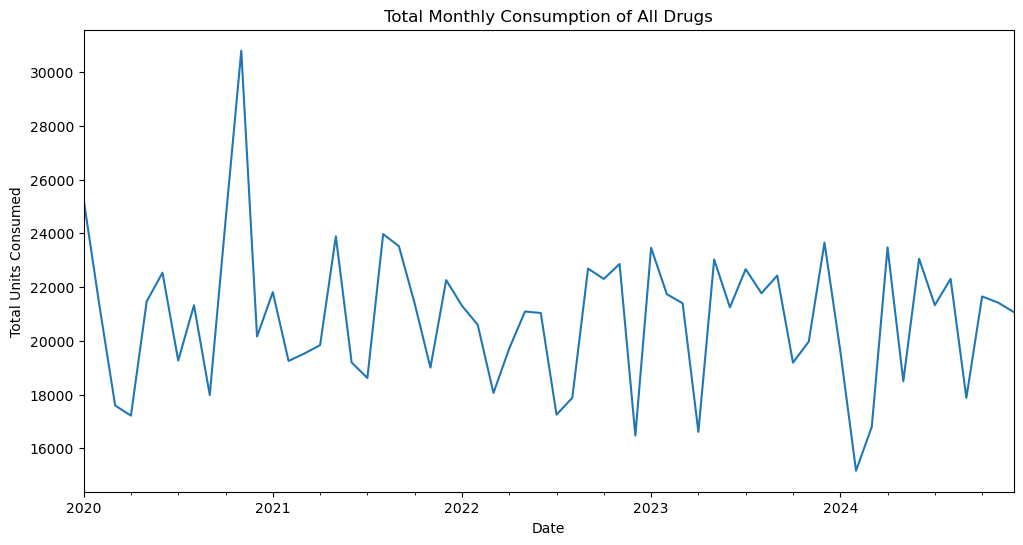

In [12]:
print("\n--- Total Monthly Consumption Over Time ---")

# Group all data by date and sum the consumption for each month
monthly_consumption = df_clean.groupby('Date')['Consumption'].sum()

# Create a line plot to see the trend
monthly_consumption.plot(figsize=(12, 6), title='Total Monthly Consumption of All Drugs')
plt.ylabel('Total Units Consumed')
plt.show()